# <div style="text-align: center"> Convex optimization for machine learning: Part 2</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Gyeongjo Hwang, Doyeon Kim</div>

# 2. 심층신경망 (Deep Neural Network)

- 이번 강의에서는 심층신경망을 구현하기위해 필요한 모든 함수를 구현할 것
- 구현한 신경망을 이미지 분류문제에 적용해 볼 것

**What you will learn to:**
- 더 깊은 층(Layer)의 신경망을 구현(1 hidden layer보다 더 깊은 DNN)

**Notation**:
- 첨자 $[l]$는 $l^{th}$층의 값들을 의미
    - 예) $a^{[L]}$는 $L^{th}$층의 활성함수 값, $W^{[L]}$과 $b^{[L]}$는 $L^{th}$층의 파라미터의 값을 의미
- 첨자 $(i)$는 $i^{th}$번째 값을 의미
    - 예) $x^{(i)}$는 $i^{th}$번째 training example를 의미
- 아래첨자 $i$는 벡터의 $i^{th}$ 번째 요소를 의미
    - 예) $a^{[l]}_i$는 $l^{th}$ 층의 활성함수 값의 $i^{th}$번째 요소를 의미
    - 예) $a^{[l](i)}_j$는 $i^{th}$번째 training example의 $l^{th}$ 층의 활성함수 값의 $j^{th}$번째 요소를 의미

In [1]:
from __future__ import division

import numpy as np
import h5py
import matplotlib.pyplot as plt
from NL_utils import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [3]:
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

##  개요

더욱 깊은 Neural network를 구현하기 위한 instruction은 다음과 같다.

- 2-layer neural network에 대하여 parameter initialization 및 $L$-layer neural network에 대하여 initialization 구현
- forward pass 모듈 구현 (figure.1 의 보라색 블록 참조).
     - 각 층의 linear 연산구현($Z^{[l]}$).
     - 활성함수(activation fuction)는 주어질 것 (ReLU/sigmoid).
     - 위의 두 연산을 [LINEAR->ACTIVATION] forward 연산으로 합침
     - 위의 [LINEAR->RELU] forward function을 L-1번 쌓는다. (for layers 1 through L-1) 그리고 마지막단에는  [LINEAR->SIGMOID] forward function을 쌓는다.(for the final layer $L$).
- 손실함수 계산
- backpropagation 모듈 구현 (figure.1 의 적색 블록 참조).
    - Linear 연산의 backpropagation 구현
    - 활성함수(activation function)의 gradient 값은 주어질 것 (relu_backward/sigmoid_backward) 
    - 위의 두 연산을 [LINEAR->ACTIVATION] backward 연산으로 합침
    - 위의 [LINEAR->RELU] backward function을 L-1번 쌓는다. 그리고 마지막 단에 [LINEAR->SIGMOID] backward function을 쌓는다.
- 마지막으로 parameter를 업데이트 한다,

<img src="figures/final outline.png" style="width:800px;">
<caption><center> Figure 1</center></caption><br>


**Note** 모든 forward() 함수는 그에 대응하는 backward() 함수가 존재하며 이는 깊은 신경망에서 gradient 계산을 쉽게 구현하기 위함이다. 이 강의에서 역시 cache를 사용하여 gradient 계산에 이용할 것이다.

## Initialization

### L-layer Neural Network

<table style="width:90%">
    <tr>
        <td>  </td> 
        <td> Shape of W </td> 
        <td> Shape of b  </td> 
        <td> Activation </td>
        <td> Shape of Activation </td> 
    <tr>
    <tr>
        <td> Layer 1 </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    <tr>
        <td> Layer 2 </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>
   <tr>
        <td> Layer L-1 </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
   <tr>
        <td> Layer L </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

파이썬 $W X + b$연산은 브로드캐스팅을 지원한다:

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$


$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

**실습 :** L-layer Neural Network의 initialization 함수를 구현하시오.

**Instructions**:
- 모델구조: *[LINEAR -> RELU] $ \times$ (L-1) -> [LINEAR -> SIGMOID]*.
- `np.random.rand(shape) * 0.01`를 이용하여 W 초기화.
- `np.zeros(shape)`를 이용하여 bias 초기화.
- 모델 층의 모든 유닛 개수를 저장하고 있는 layer_dim리스트 값을 인풋으로 받는다.

예) $L=1$에 대한 파라미터 초기화: 
```python
if L == 1:
    parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
    parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [4]:
def initialize_parameters_deep(layer_dims):
    """
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [5]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[0.]
 [0.]
 [0.]]


W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]<br>
b1 = [[0.]
 [0.]
 [0.]
 [0.]]<br>
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]<br>
b2 = [[0.]
 [0.]
 [0.]]

## Forward propagation module

### Linear Forward 
다음 세개의 연산을 차례로 구현할 것

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

Linear forward연산은 다음과 같다(Vectorized version):

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

**실습 :** Linear foward를 구현하시오.

**Tip**:

$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$ 계산시 `np.dot()`가 유용. Dimension 체크는`W.shape`이용

In [7]:
def linear_forward(A, W, b):
    """
    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W, A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [8]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


Z = [[ 3.26295337 -1.23429987]]

### Linear-Activation Forward

다음 두 활성함수를 사용:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. 

- **ReLU**: $A = RELU(Z) = max(0, Z)$. 

`sigmoid` 및 `relu` function는 제공될 것이고 다음 **2개**의 값을 리턴한다:

the activation value "`a`" , a "`cache`"

``` python
A, activation_cache = sigmoid(Z)
```

``` python
A, activation_cache = relu(Z)
```

**실습 :**  *LINEAR->ACTIVATION* layer를 구현하시오. 

**Note :**Mathematical relation: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu().

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]

### L-Layer Model 

L-layer model을 구현하기 위해서는 앞서 구현한 linear->activation 연산[`linear_activation_forward` with RELU]를 $L-1$번, [`linear_activation_forward` with SIGMOID]를 한 번 쌓아야 한다.

<img src="figures/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> Figure 2 : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

**Exercise**: 위 figure2 모델의 forward연산을 구현하시오.

**Instruction**: 파이썬 변수 `AL`는 $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$를 나타냄 (=`Yhat`, i.e., $\hat{Y}$.) 

**Tips**:
- 앞서 구현한 forward모듈을 사용하시오 
- for loop를 사용하시오 ([LINEAR->RELU] 연산 (L-1) 번)
- `list.append(c)`메소드를 이용하여 cache값을 저장하시오

In [11]:
def L_model_forward(X, parameters):
    """
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, 
                                             parameters["W" + str(l)], 
                                             parameters["b" + str(l)], 
                                             activation='relu')
        caches.append(cache)

        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, 
                                             parameters["W" + str(L)], 
                                             parameters["b" + str(L)], 
                                             activation='sigmoid')
    caches.append(cache)
    
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [12]:
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
Length of caches list = 2


AL = [[0.17007265 0.2524272 ]]
Length of caches list = 2

## Cost function 구현

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [13]:
def compute_cost(AL, Y):
    """
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = (-1./ m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log( 1-AL)))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [14]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.41493159961539694


cost = 0.41493159961539694

## Backpropagation module


**Reminder**: 
<img src="figures/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center> Figure 3 : Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID<br> </center></caption>

- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### Linear backward

linear part: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

$dZ^{[l]} = \dfrac{\partial J }{\partial Z^{[l]}}$ 값만 계산되고 나면 $(dW^{[l]}, db^{[l]} dA^{[l-1]})$ 값들을 차례로 계산할 수 있음

<img src="figures/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center> Figure 4 </center></caption>

$dZ^{[l]}$값을 이용하여 세 값 $(dW^{[l]}, db^{[l]}, dA^{[l]})$ 을 계산:
$$ dW^{[l]} = \dfrac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \dfrac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \dfrac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

**실습 :**  위 식을 참고하여 linear_backward()를 구현하시오.

In [15]:
def linear_backward(dZ, cache):
    """
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = np.dot(dZ, cache[0].T) 
    db = np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache[1].T, dZ)
    ### END CODE HERE ###

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [16]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.2015379   2.81370193  3.2998501 ]]
db = [[1.01258895]]


dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]<br>
dW = [[-0.2015379   2.81370193  3.2998501 ]]<br>
db = [[1.01258895]]

### 6.2 - Linear-Activation backward

 **`linear_backward`** 를 이용하여 **`linear_activation_backward`** 를 구현 

$g(.)$가 활성함수(activation function)일 때,
`sigmoid_backward` and `relu_backward`는 $dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$를 계산  

**Exercise**:  *LINEAR->ACTIVATION* layer 의backpropagation를 구현하시오

In [17]:
def linear_activation_backward(dA, cache, activation):
    """
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [18]:
AL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.20533573  0.19557101 -0.03936168]]
db = [[-0.11459244]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.89027649  0.74742835 -0.20957978]]
db = [[-0.41675785]]


sigmoid:<br>
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]<br>
dW = [[ 0.20533573  0.19557101 -0.03936168]]<br>
db = [[-0.11459244]]<br>

relu:<br>
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]<br>
dW = [[ 0.89027649  0.74742835 -0.20957978]]<br>
db = [[-0.41675785]]

### 6.3 - L-Model Backward 

앞서 `L_model_forward` function을 구현한 것과 같은 방식으로 `L_model_backward` function을 구현해 볼 것이다.


<img src="figures/mn_backward.png" style="width:450px;height:300px;">
<caption><center>  Figure 5 : Backward pass  </center></caption>

`dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$를 계산하기 위해서는
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```
를 이용

L_model_forward에서 cache에 저장된 (X,W,b, and z)값들과 for loop를 이용하여 다음과 같이 구현:

$$grads["dW" + str(l)] = dW^{[l]}$$

ex) $l=3$층의 파라미터 $dW^{[l]}$는 `grads["dW3"]`안에서 retrieve

**실습 :** *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID*  모델의 backpropagation 구현

In [19]:
def L_model_backward(AL, Y, caches):
    """
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = (1 / m) * ( - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    ### END CODE HERE ###
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation="relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [20]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.26128951]
 [ 0.         -0.1634603 ]
 [ 0.         -0.16035202]
 [ 0.         -0.37039594]]


dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]<br>
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]<br>
dA1 = [[ 0.          0.26128951]
 [ 0.         -0.1634603 ]
 [ 0.         -0.16035202]
 [ 0.         -0.37039594]]<br>

### 6.4 - Update Parameters

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

where $\alpha$ is the learning rate.

**실습 :** 파라미터 업데이트를 위한 `update_parameters()`함수를 구현하시오

**Instructions**:
모든 $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$ 에 대하여 업데이트 (for loop 이용)

In [21]:
def update_parameters(parameters, grads, learning_rate):
    """
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
        
    return parameters

In [22]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]<br>
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]<br>
W2 = [[-0.55569196  0.0354055   1.32964895]]<br>
b2 = [[-0.84610769]]

## 7. L-layer Neural Network

**7-1.하나의 L_layer_model 함수로 구현해보기**

In [23]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [24]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

**7-2. Prediction**

(12288, 209)
Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


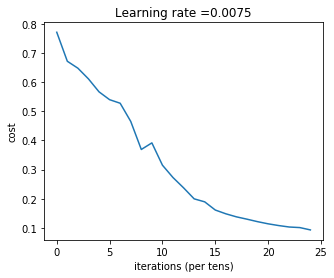

In [25]:
# (cat/non-cat) 데이터셋 로드
from RL_utils import load_dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
Y_train = Y_train_orig.reshape(1, -1)
Y_test = Y_test_orig.reshape(1, -1)

print(X_train.shape)
parameters = L_layer_model(X_train, Y_train, layers_dims, num_iterations=2500, print_cost=True)

### Get accuracy of the trained model on train/test datasets

In [26]:
yhat_train, _ = L_model_forward(X=X_train, parameters=parameters)
yhat_test, _ = L_model_forward(X=X_test, parameters=parameters)

y_pred_train = (yhat_train > 0.5)
y_pred_test = (yhat_test > 0.5)

print("Train acc: {:.3%}".format(np.sum(y_pred_train == Y_train) / Y_train.shape[1]))
print("Test acc: {:.3%}".format(np.sum(y_pred_test == Y_test) / Y_test.shape[1]))

Train acc: 98.565%
Test acc: 80.000%
